This notebook implements the Naive Bayes and Logistic Regression with Stochastic Gradient Descent from scratch.

In [1]:
import pandas as pd
import numpy as np
import scipy
import pickle
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Getting Data

In [2]:
#getting feature names
with open("feature_names.txt", "rb") as fp:
    feature_names = pickle.load(fp)

In [3]:
#loading data and splitting it into train and test
def get_train_test():
    data_sparse = scipy.sparse.load_npz('data_sparse.npz')
    
    y = data_sparse[:,0]
    X = data_sparse[:,1:]
    
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test()

# Loss Function

In order to compare the algorithms, one needs to specify the loss function. Since all algorithms discussed here predict probabilities, I use logistic loss function to compare them. The Log Loss is given by:
\begin{equation}
Log Loss =-\left[y_{t} \log \left(p_{t}\right)+\left(1-y_{t}\right) \log \left(1-p_{t}\right)\right]
\end{equation}
where vector $p_t$ denotes predicted probability for observation $t$ and $y_t \in \{0,1\}$ denotes where there was a click for observation $t$.

In [4]:
#y is a sparse matrix of dimension Tx1
#p is a matrix of dimension Tx1 or a vector of size T
def loss(p, y):
    
    #convert sparse matrix to regular matrix
    #this is done as sparse matrices do not support additions / substractions
    y = y.A
    
    #reshaping
    y = y.reshape(-1)
    p = p.reshape(-1)
    
    return (-y * np.log(p) - (1 - y) * np.log(1 - p)).mean()

# Naive Bayes

Under assumption of conditional independence and using Bayes theorem, one can show that probability of click given set of features $X$ can be obtained using:
\begin{equation}
P(Y=1 \mid X=x) =\frac{P(Y=1) \prod_{i} P\left(X_{i}=x_{i} \mid Y=1\right)}{P(Y=1) \prod_{i} P\left(X_{i}=x_{i} \mid Y=1\right) + P(Y=0) \prod_{i} P\left(X_{i}=x_{i} \mid Y=0\right)}
\end{equation} \
where $P\left(X_{i}=x_{i} \mid Y=1\right)$ denotes probabilty of feature $X_i$ taking a value $x_i$ given that there is a click. To ensure feasibility and dramatically reduce calaculation time, the code below is based on sparse matrices from the package scipy.sparse. Using logarithms, one obtains alternative expression:
\begin{equation}
P(Y=1) \prod_{i} P\left(X_{i}=x_{i} \mid Y=1\right) = \exp \{{\log \{{P(Y=1) \prod_{i} P\left(X_{i}=x_{i} \mid Y=1\right)}\} \}} = \exp \{ {\log{P(Y=1)} + \sum_{i} \log{P\left(X_{i}=x_{i} \mid Y=1\right)}}\}
\end{equation}
This simplifies the calculations. However, estimated probability can be zero (no observations for particular feature vaue given click or no click). Consequently, zero probabilities are replaced by smallest positive values encountered.

In [5]:
#function that replaces zero probabilities by small values
def replace_zero_probabilities(all_probabilities_given_click, all_probabilities_given_no_click):
    
    min_click = np.min(all_probabilities_given_click[all_probabilities_given_click > 0])
    all_probabilities_given_click[all_probabilities_given_click == 0] = min_click

    min_no_click = np.min(all_probabilities_given_no_click[all_probabilities_given_no_click > 0])
    all_probabilities_given_no_click[all_probabilities_given_no_click == 0] = min_no_click
    
    return all_probabilities_given_click, all_probabilities_given_no_click

In [6]:
#function that calculates probabilities of features given click and no click
def get_conditional_probabilities_of_features(X_train, X_test, y_train, y_test):
    
    #getting the indices of rows correponding to click and not click
    click_bol = y_train.A.reshape(-1)
    no_click_bol = 1 - click_bol
    list_of_indices_click = np.array((np.where(click_bol))).tolist()[0]
    list_of_indices_no_click = np.array((np.where(no_click_bol))).tolist()[0]
    
    #getting matrices of features corresponding to observations with click and no click
    click_sparse = X_train[list_of_indices_click,:]
    no_click_sparse = X_train[list_of_indices_no_click,:]

    #getting probabilities for each set of features given click and no click
    all_probabilities_given_click = np.array(click_sparse.mean(axis=0).tolist()[0])
    all_probabilities_given_no_click = np.array(no_click_sparse.mean(axis=0).tolist()[0])
    
    #replacing zero probabilities
    all_probabilities_given_click, all_probabilities_given_no_click = replace_zero_probabilities(
        all_probabilities_given_click, all_probabilities_given_no_click)
    
    return all_probabilities_given_click, all_probabilities_given_no_click

In [7]:
#function that returns probabilities estimated by Naive Bayes on test set
def naive_bayes_sparse(X_train, X_test, y_train, y_test):
    
    all_probabilities_given_click, all_probabilities_given_no_click = get_conditional_probabilities_of_features(
        X_train, X_test, y_train, y_test)

    #getting logs of probabilities
    all_probabilities_given_click_logs = np.log(all_probabilities_given_click)
    all_probabilities_given_no_click_logs = np.log(all_probabilities_given_no_click)

    #summing probabilities - using dot product
    sum_logs_probabilities_given_click = X_test.dot(all_probabilities_given_click_logs)
    sum_logs_probabilities_given_no_click = X_test.dot(all_probabilities_given_no_click_logs)

    #getting logs of probabilities of click and no click
    prob_click = y_train.mean()
    log_p_click = np.log(prob_click)
    log_p_no_click = np.log((1 - prob_click))
    
    #adding all probabilities
    log_probability_num = sum_logs_probabilities_given_click + log_p_click
    log_probability_den = sum_logs_probabilities_given_no_click + log_p_no_click
    numerator = np.exp(log_probability_num)
    denominator = numerator + np.exp(log_probability_den)
    probs = numerator / denominator
    
    return probs

In [8]:
probs_naive_bayes = naive_bayes_sparse(X_train, X_test, y_train, y_test)

In [9]:
loss_naive_bayes = loss(probs_naive_bayes, y_test)

# Logistic Regression with SGD

Due to the high dimension of the matrix in this problem, classical logistic regression is infeasible since the matrix cannot be inverted. Hence, Stochastic Gradient Descent is applied to this problem. Same as in Naive Bayes, the code uses sparse matrices to ensure feasibility and reduce calculation times. For the loss function specified above, the gradient is given by:
\begin{equation}
\nabla Log Loss=\left(p_{t}-y_{t}\right) x_{t}
\end{equation}
Hence, the weights are updated in the following way:
\begin{equation}
w_{t+1} = w_{t}-\eta_{t}\left(p_{t}-y_{t}\right) x_{t}
\end{equation}


In [10]:
def logit(w,x):
    w = scipy.sparse.csr_matrix(w).reshape(-1,1)
    p = 1/(1+np.exp(-((x.dot(w)).A)))
    return (p)

#p is Nx1 ; x is Nxk ; weights are kx1
def grad(p,y,X,learning_rate):
    
    score = learning_rate*X.transpose().dot(p-y)
    return np.array(score)

def update_weights(y,X,w,learning_rate):
    
    # get probabilities
    p = logit(w,X).reshape(-1,1)
    
    # get score
    score = grad(p,y,X,learning_rate)
    
    # update w
    w = w - score
    
    return p, w

def sgd_iterative(chunksize, X_train, y_train):
    
    total_chunks = int(X_train.shape[0] / chunksize)
    
    #initializing weights
    w = np.zeros(X_train.shape[1]).reshape(-1,1)
    weights_matrix = np.zeros((X_train.shape[1],total_chunks+1))
    weights_matrix[:,0] = w.reshape(-1)
    
    #initializing log_likelihood
    log_likelihood = np.zeros(total_chunks)
    
    #for each chunk update weights
    for chunk_no in range(total_chunks):
        X_chunk = X_train[chunk_no*chunksize:(chunk_no+1)*chunksize,:]
        y_chunk = y_train[chunk_no*chunksize:(chunk_no+1)*chunksize,:]
        
        #adaptive learning rate
        learning_rate = 1 /(np.sqrt(chunk_no+1) * 10000)
        
        #updating weights
        p, w = update_weights(y_chunk, X_chunk, w, learning_rate)
        
        #getting log_likelihood
        log_likelihood[chunk_no] = loss(p, y_chunk)
        
        #updating matrix of weights
        weights_matrix[:, chunk_no+1] = w.reshape(-1)
        
    return p, w, weights_matrix, log_likelihood

In [11]:
#large chunks as we have around 32 million observations in the train set
chunksize = 100000
p_train, w, weights_matrix, log_likelihood = sgd_iterative(chunksize, X_train, y_train)

In [12]:
#obtaining probabilities and loss on test set
probs_logistic = logit(w, X_test)
loss_logistic = loss(probs_logistic, y_test)

Text(0.5, 1.0, 'Log_likelihood on the train set in each iteration')

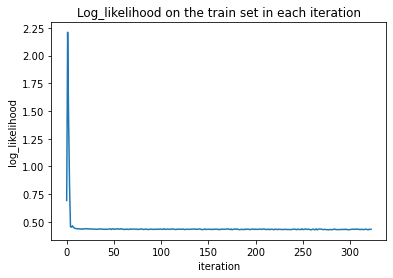

In [13]:
#visualizing log_likelihood on the train set as weights are updates
plt.plot(log_likelihood)
plt.ylabel('log_likelihood')
plt.xlabel('iteration')
plt.title('Log_likelihood on the train set in each iteration')

Text(0.5, 1.0, 'Weights of some features in each iteration')

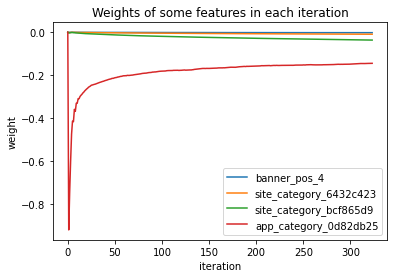

In [14]:
#visualizing how some weights are updated
indices_weights = [10,20,30,40]
weights_names = list(feature_names[i] for i in indices_weights)
plt.plot(weights_matrix[indices_weights,:].T)
plt.legend(weights_names)
plt.ylabel('weight')
plt.xlabel('iteration')
plt.title('Weights of some features in each iteration')

# Heuristic Method

To get a benchmark, I calculate the loss resulting from predicting the average click ratio.

In [15]:
prob_click = y_train.mean()

In [16]:
prob_vector_test = np.repeat(prob_click, X_test.shape[0])

In [17]:
loss_heuristic = loss(prob_vector_test, y_test)

# Comparison

In [18]:
print("Loss from Naive Bayes: ", loss_naive_bayes)
print("Loss from Logistic Regression: ", loss_logistic)
print("Loss from Heuristic Method: ", loss_heuristic)

Loss from Naive Bayes:  0.46317780185673807
Loss from Logistic Regression:  0.43258907835175486
Loss from Heuristic Method:  0.4554626127300109
